In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from outputting_functions import *
from feature_engineering import *
from models import *

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

log = True

print('Reading in data..')

test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')

test['SalePrice'] = np.nan
y_train, y_test = train['SalePrice'].values, test['SalePrice'].values

if log:
    y_train = np.log1p(y_train)
    print('Taking the log of the outcome variable')

numeric_vars = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
               'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
               'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'YearRemodAdd', 'YearBuilt', 'MasVnrArea']

print('Creating holdout set (30%) from the training set..')

train, valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.3, random_state=0)             
X_train, X_test, X_valid = data_formatting(train, test, valid, numeric_vars, log, False)               

Reading in data..
Taking the log of the outcome variable
Creating holdout set (30%) from the training set..
Recoding data errors..
Formatting data..
Generating aggregate features..
Generating numeric features that will be scaled..
Taking the log of numeric variables
Generating numeric features that won't be scaled
Generating area features..
Generating new categorical features..
Re-separating into test and train sets..


In [2]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [3]:
model_ridge = Ridge()

In [4]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

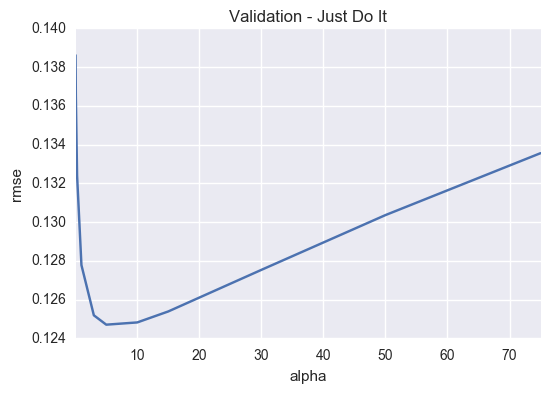

In [5]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse");

In [6]:
cv_ridge.min()

0.12470502873964015

In [7]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [8]:
rmse_cv(model_lasso).mean()

0.12393182019265439

In [9]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

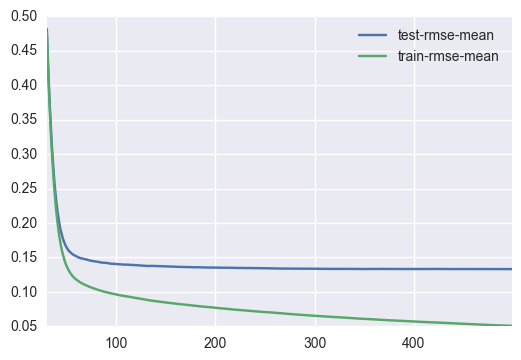

In [10]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [11]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [12]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

## The below code won't work.. :(

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV        

target_param_grid = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}


xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, colsample_bytree=0.8, nthread=2, scale_pos_weight=1, seed=27)

gsearch = GridSearchCV(estimator = xgb_model, param_grid = target_param_grid, n_jobs=2, scoring='neg_mean_squared_error')
gsearch.fit(X_train, y_train)

## Doing some work on a rf/pca pipeline

I think there might be some validity to this approach as the lasso regression has been so successful

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
clf = RandomForestRegressor()

cols = X_train.shape[1]
n_components = list(range(0, cols, 2))
n_components[0] = 1

pca = PCA()
rf = RandomForestRegressor(n_estimators = 200, min_samples_leaf = 1, 
                           min_samples_split = 2, max_depth = None, bootstrap = False)
pipe = Pipeline(steps=[('pca', pca), ('rf', rf)])

n_ests = [50, 100, 200]
max_depth = [3, None]
max_feat = [1, 3, 10]
min_samples = [2, 3, 10]
min_samples_leaf = [1, 3, 10]
boot = [True, False]

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))

estimator.fit(X_train, y_train)

KeyboardInterrupt: 

In [15]:
print (estimator.grid_scores_)
print('best params')
print (estimator.best_params_)
print('best score')
print (estimator.best_score_)

[mean: -0.16755, std: 0.23078, params: {'pca__n_components': 1}, mean: 0.27735, std: 0.01835, params: {'pca__n_components': 2}, mean: 0.26976, std: 0.12539, params: {'pca__n_components': 4}, mean: 0.42731, std: 0.04819, params: {'pca__n_components': 6}, mean: 0.54093, std: 0.03962, params: {'pca__n_components': 8}, mean: 0.54612, std: 0.04582, params: {'pca__n_components': 10}, mean: 0.58831, std: 0.03334, params: {'pca__n_components': 12}, mean: 0.62354, std: 0.04155, params: {'pca__n_components': 14}, mean: 0.62600, std: 0.04674, params: {'pca__n_components': 16}, mean: 0.67235, std: 0.02452, params: {'pca__n_components': 18}, mean: 0.70332, std: 0.02827, params: {'pca__n_components': 20}, mean: 0.71077, std: 0.02407, params: {'pca__n_components': 22}, mean: 0.71023, std: 0.02877, params: {'pca__n_components': 24}, mean: 0.71539, std: 0.01992, params: {'pca__n_components': 26}, mean: 0.71262, std: 0.02112, params: {'pca__n_components': 28}, mean: 0.71930, std: 0.01203, params: {'pca_

C:\Users\evanm_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## Now working on some ensembling code..

In [40]:
n_models = 2
model_1 = 'lassocv'
model_2 = 'xgboost'

model_file_1 = 'Model Outputs/' + model_1 + '_output.csv'
model_file_2 = 'Model Outputs/' + model_2 + '_output.csv'
ensemble_file = 'Model Outputs/' + model_1 + '_' + model_2 + '_output.csv'

m1 = pd.read_csv(model_file_1, index_col = 'Id')
m2 = pd.read_csv(model_file_2, index_col = 'Id')

ensemble = pd.DataFrame(index = test['Id'])
ensemble['SP1'] = m1['SalePrice']
ensemble['SP2'] = m2['SalePrice']

ensemble['SalePrice'] = ensemble.mean(axis = 1)
ensemble = ensemble['SalePrice']

ensemble.to_csv(ensemble_file, header=True, index_label='Id')

## Working on some stacking code..

In [31]:
models = ['rngr_logged.csv', 'gbm_logged.csv', 'rfcv_logged.csv',
          'lassocv_logged.csv', 'xgboost_logged.csv']

for idx, model in enumerate(models):
    
    file = 'Model outputs/' + model
    col = model.split('_')[0]

    if idx == 0:
        
        results = pd.read_csv(file)
        results=results.rename(columns = {'SalePrice':col})

    else:
        df = pd.read_csv(file)
        df = df.rename(columns = {'SalePrice':col})
        df = df.drop('Id', axis = 1)
        results = pd.concat([results, df], axis=1)

In [32]:
results.head()

,Id,rngr,gbm,rfcv,lassocv,xgboost
0,1461,11.728011,11.691508,11.812342,11.688504,11.703410
1,1462,11.909484,11.967364,12.050798,12.008140,12.044088
2,1463,12.086664,12.154010,12.087087,12.118388,12.078257
3,1464,12.084096,12.122050,12.122061,12.195209,12.138227
4,1465,12.148377,12.134301,12.177212,12.174578,12.186873


In [33]:
var = "datetime"
